# Installing the libraries

In [ ]:
!pip install -q -U 'tensorflow-text==2.8.*'
!pip install -q tf-models-official==2.7.0
!pip install contractions
!pip install emoji

     |████████████████████████████████| 4.9 MB 4.7 MB/s 
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 42.2 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 1.3 MB 47.0 MB/s 
     |████████████████████████████████| 116 kB 72.7 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 352 kB 57.3 MB/s 
     |████████████████████████████████| 238 kB 26.1 MB/s 
     |████████████████████████████████| 99 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 4.5 MB/s 
     |████████████████████████████████| 287 kB 33.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none

# Import the libraries

In [ ]:
import os
from os import path
import shutil
import pickle
from google.colab import drive
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


import string
import re
import nltk
from nltk.tokenize import word_tokenize
import contractions
from nltk.stem.porter import PorterStemmer
import emoji 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

tf.get_logger().setLevel('ERROR')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading the data

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/Incongruence_Data/data_text/nike.zip -d textual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_text/gucci.zip -d textual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_text/cristianoronaldo.zip -d textual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_text/edsheeran.zip -d textual_data

!unzip gdrive/MyDrive/Incongruence_Data/data_image/nike.zip -d visual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_image/gucci.zip -d visual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_image/cristianoronaldo.zip -d visual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_image/edsheeran.zip -d visual_data

Streaming output truncated to the last 5000 lines.
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-42-25_/2022-06-26_13-42-25_UTC_6.jpg  
   creating: visual_data/edsheeran/Matches/2022-06-26_13-43-06_/
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-43-06_/2022-06-26_13-43-06_UTC.jpg  
   creating: visual_data/edsheeran/Matches/2022-06-26_13-45-22_/
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-45-22_/2022-06-26_13-45-22_UTC_1.jpg  
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-45-22_/2022-06-26_13-45-22_UTC_10.jpg  
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-45-22_/2022-06-26_13-45-22_UTC_2.jpg  
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-45-22_/2022-06-26_13-45-22_UTC_3.jpg  
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-45-22_/2022-06-26_13-45-22_UTC_4.jpg  
  inflating: visual_data/edsheeran/Matches/2022-06-26_13-45-22_/2022-06-26_13-45-22_UTC_5.jpg  
  inflating: visual_data/edsheeran/Matches/2022-06-2

In [ ]:
def get_df(name):
  with open('gdrive/MyDrive/Incongruence_Data/data_text/' + name + '_data_list.pickle', 'rb') as handle:
    data = pickle.load(handle)
  df = pd.DataFrame(data, columns=['file_name', 'caption2', 'caption', 'class'])
  df.drop(columns=['caption2'], inplace=True)
  return df

In [ ]:
def preprocess(df):
  
  # Lowering the text
  df['caption'] = df['caption'].apply(lambda x: x.lower())

  # Expand Contractions
  contractions_text = []
  for caption in df['caption'].values:
    expanded_words = []   
    for word in caption.split():
      expanded_words.append(contractions.fix(word))  
    contractions_text.append(' '.join(expanded_words))
  df['caption'] = contractions_text

  # Emoji Conversion
  df['caption'] = df['caption'].apply(lambda x: emoji.demojize(x))
  df['caption'] = df['caption'].apply(lambda x: x.replace(':', ' '))

  # Punctuation Removal
  # data = []
  # special_punctuation = '#_@:.【】'
  # for caption in df['caption'].values:
  #   for char in caption:
  #     if char in string.punctuation:
  #       if char in special_punctuation:
  #         caption = caption.replace(char, ' ')
  #       else:
  #         caption = caption.replace(char, '')
  #   data.append(caption)
  # df['caption'] = data

  # Tokenization
  # df['tokenized_caption'] = df['caption'].apply(lambda x: word_tokenize(x))

  # Stop word removal
  # stopwords = nltk.corpus.stopwords.words('english')
  # df['tokenized_caption'] = df['tokenized_caption'].apply(lambda x:[i for i in x if i not in stopwords])

  # Stemming
  # porter_stemmer = PorterStemmer()
  # df['tokenized_caption'] = df['tokenized_caption'].apply(lambda x: [porter_stemmer.stem(word) for word in x])
  # df['caption'] = df['tokenized_caption'].apply(lambda x: ' '.join(x))

  # df.drop(columns=['tokenized_caption'], inplace=True)

  return df

In [ ]:
def get_ocr_text(name):
  with open('gdrive/MyDrive/Incongruence_Data/data_text/' + name + '_data_OCR.pickle', 'rb') as handle:
    data = pickle.load(handle)
  return data

In [ ]:
def preprocess_ocr(df):
  # Lowering the text
  df['ocr_text'] = df['ocr_text'].apply(lambda x: x.lower())

  # Expand Contractions
  contractions_text = []
  for caption in df['ocr_text'].values:
    expanded_words = []   
    for word in caption.split():
      expanded_words.append(contractions.fix(word))  
    contractions_text.append(' '.join(expanded_words))
  df['ocr_text'] = contractions_text

  # Punctuation Removal
  # data = []
  # special_punctuation = '#_@:.【】'
  # for caption in df['ocr_text'].values:
  #   for char in caption:
  #     if char in string.punctuation:
  #       if char in special_punctuation:
  #         caption = caption.replace(char, ' ')
  #       else:
  #         caption = caption.replace(char, '')
  #   data.append(caption)
  # df['ocr_text'] = data

  # Tokenization
  # df['tokenized_ocr'] = df['ocr_text'].apply(lambda x: word_tokenize(x))

  # Stop word removal
  # stopwords = nltk.corpus.stopwords.words('english')
  # df['tokenized_ocr'] = df['tokenized_ocr'].apply(lambda x:[i for i in x if i not in stopwords])

  # Stemming
  # porter_stemmer = PorterStemmer()
  # df['tokenized_ocr'] = df['tokenized_ocr'].apply(lambda x: [porter_stemmer.stem(word) for word in x])
  # df['ocr_text'] = df['tokenized_ocr'].apply(lambda x: ' '.join(x))

  # df.drop(columns=['tokenized_ocr'], inplace=True)
  
  return df

In [ ]:
def data_augmentation(df):
  new_df = pd.DataFrame(columns=list(df))
  for row in df.iloc[:, :].values:
    imgs = row[4]
    for img in imgs:
      new_df.loc[len(new_df.index)] = [row[0], row[1], row[2], row[3] + img, row[4], row[5]]
  new_df.drop(columns=['image_name'], inplace=True)
  return new_df

In [ ]:
def add_visual_data(dataframe, data_name):
  images = []
  vis_path = 'visual_data/'+ data_name + '/Matches/'
  vis_path2 = 'visual_data/'+ data_name + '/Mismatches/'
  vis_data_list = os.listdir(vis_path)
  vis_data_list2 = os.listdir(vis_path2)

  for file in dataframe['file_name'].values:
    file_name = file.split('UTC')[0]
    
    if file_name in vis_data_list:
      imgs = os.listdir(vis_path + file_name)
      if len(imgs) == 0:
        images.append('')
      else:
        images.append(vis_path + file_name + '/' + imgs[0])

    elif file_name in vis_data_list2:
      imgs = os.listdir(vis_path2 + file_name)
      if len(imgs) == 0:
        images.append('')
      else:
        images.append(vis_path2 + file_name + '/' + imgs[0])

  return images

In [ ]:
def add_visual_data_aug(dataframe, data_name):
  images = []
  all_images = []
  vis_path = 'visual_data/'+ data_name + '/Matches/'
  vis_path2 = 'visual_data/'+ data_name + '/Mismatches/'
  vis_data_list = os.listdir(vis_path)
  vis_data_list2 = os.listdir(vis_path2)

  for file in dataframe['file_name'].values:
    file_name = file.split('UTC')[0]
    
    if file_name in vis_data_list:
      imgs = os.listdir(vis_path + file_name)
      if len(imgs) == 0:
        images.append('')
        all_images.append('')
      else:
        images.append(vis_path + file_name + '/')
        all_images.append(imgs)

    elif file_name in vis_data_list2:
      imgs = os.listdir(vis_path2 + file_name)
      if len(imgs) == 0:
        images.append('')
        all_images.append('')
      else:
        images.append(vis_path2 + file_name + '/')
        all_images.append(imgs)
  
  return images, all_images

In [ ]:
def prepare_final_df(name, augment):
  df = get_df(name)
  df = preprocess(df)
  ocr_list = get_ocr_text(name)
  try:
    df['ocr_text'] = ocr_list
  except ValueError:
    ocr_list.append('')
    df['ocr_text'] = ocr_list
  df = preprocess_ocr(df)
  
  if augment:
    df['image_path'], df['image_name'] = add_visual_data_aug(df, name)
    df['image_exist'] = [path.exists(i) for i in df['image_path'].values]
    df = df[df['image_exist']]
    df.drop(columns=['image_exist'], inplace=True)
    df = df[['file_name', 'caption', 'ocr_text', 'image_path', 'image_name', 'class']]
    df = data_augmentation(df)
  else:
    df['image_path'] = add_visual_data(df, name)
    df['image_exist'] = [path.exists(i) for i in df['image_path'].values]
    df = df[df['image_exist']]
    df.drop(columns=['image_exist'], inplace=True)
    df = df[['file_name', 'caption', 'ocr_text', 'image_path', 'class']]

  return df

In [ ]:
df_nike = prepare_final_df('nike', True)
df_cristianoronaldo = prepare_final_df('cristianoronaldo', True)
df_edsheeran = prepare_final_df('edsheeran', True)
df_gucci = prepare_final_df('gucci', True)

df = df_nike.append([df_gucci, df_cristianoronaldo, df_edsheeran])

## Dataset visualization

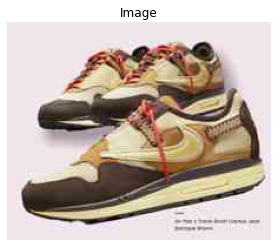

Text one: caramel modafemininaonline #modacaracas #nike#nikeoriginal#airmax
Text two: air max 1 travis scott cactus jack baroque brown
Label: 1


In [ ]:
# idx = np.random.choice(len(df))
current_row = df.iloc[1773]
image = plt.imread(current_row['image_path'])
caption = current_row['caption']
ocr = current_row['ocr_text']
label = current_row['class']

plt.imshow(image)
plt.axis('off')
plt.title('Image')
plt.show()

print(f'Text one: {caption}')
print(f'Text two: {ocr}')
print(f'Label: {label}')

# Multimodal Model

## Load the Bert model

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_path = map_name_to_handle[bert_model_name]
bert_preprocess_path = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', bert_model_path)
print('Preprocessing model auto-selected:', bert_preprocess_path)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Bert preprocess model

In [ ]:
input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in ['caption', 'OCR']]
bert_preprocess = hub.load(bert_preprocess_path)
tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
segments = [tokenizer(s) for s in input_segments]
truncated_segments = segments
packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs, arguments=dict(seq_length=128), name='packer')
model_inputs = packer(truncated_segments)
bert_preprocess_model = keras.Model(input_segments, model_inputs)

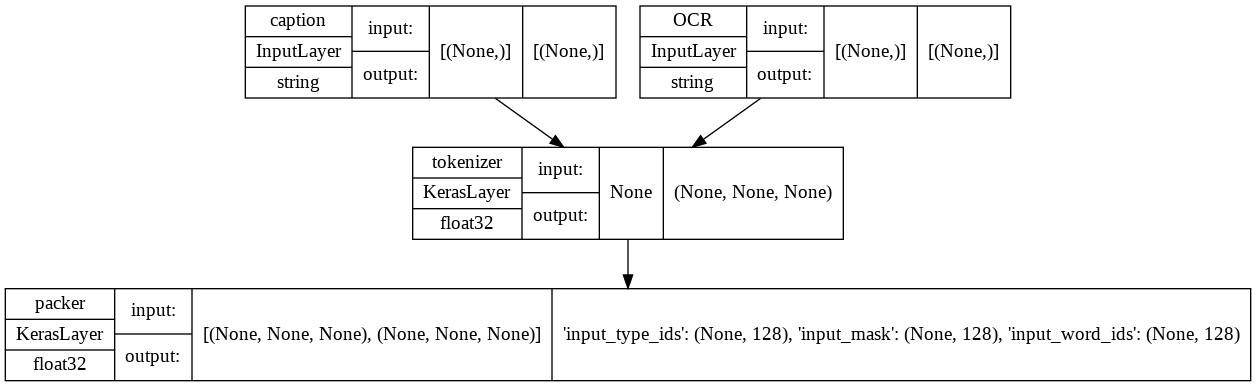

In [ ]:
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

In [ ]:
def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b'jpg':
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

In [ ]:
def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output

In [ ]:
def preprocess_text_and_image(sample):
    image = preprocess_image(sample['image_path'])
    text = preprocess_text(sample['caption'], sample['ocr_text'])
    return {'image': image, 'text': text}

In [ ]:
def prepare_dataset(dataframe, training=True):
  columns = ['image_path', 'caption', 'ocr_text', 'class']
  dataframe = dataframe[columns].copy()
  labels = dataframe.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  ds = ds.shuffle(buffer_size=len(dataframe))

  if training:
      ds = ds.shuffle(len(dataframe))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

## Building the multimodal model

In [ ]:
auto = tf.data.AUTOTUNE
batch_size = 32
resize = (128, 128)

bert_input_features = ['input_word_ids', 'input_type_ids', 'input_mask']

In [ ]:
attention = True

image = keras.Input(shape=(128, 128, 3), name='image')
text_inputs = {feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature) for feature in bert_input_features}

# vision_encoder
resnet_v2 = keras.applications.ResNet50V2(include_top=False, weights='imagenet', pooling='avg')
for layer in resnet_v2.layers:
  layer.trainable = False
preprocessed = keras.applications.resnet_v2.preprocess_input(image)
vision_embeddings = resnet_v2(preprocessed)


# vision project embeddings
projected_embeddings = keras.layers.Dense(units=128)(vision_embeddings)
x = tf.nn.gelu(projected_embeddings)
x = keras.layers.Dense(128)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Add()([projected_embeddings, x])
vision_outputs = keras.layers.BatchNormalization()(x)

# text encoder
bert = hub.KerasLayer(bert_model_path, name='bert')
bert.trainable = False
text_embeddings = bert(text_inputs)['pooled_output']

# text project embeddings
projected_embeddings = keras.layers.Dense(units=128)(text_embeddings)
y = tf.nn.gelu(projected_embeddings)
y = keras.layers.Dropout(0.2)(y)
y = keras.layers.Dense(128)(y)
y = keras.layers.Add()([projected_embeddings, y])
text_outputs = keras.layers.BatchNormalization()(y)

vision_encoder = keras.Model([image], vision_outputs, name='vision_encoder')
text_encoder = keras.Model(text_inputs, text_outputs, name='text_encoder')



# Fetch the embedding projections.
vision_projections = vision_encoder([image])
text_projections = text_encoder(text_inputs)

vision_projections = keras.layers.Dropout(0.2)(vision_projections)
text_projections = keras.layers.Dropout(0.2)(text_projections)

# if attention:
#   query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)([vision_projections, text_projections])


# Concatenate the projections and pass through the classification layer.
concatenated = keras.layers.Concatenate()([vision_projections, text_projections])

# if attention:
#   concatenated = keras.layers.Concatenate()([concatenated, query_value_attention_seq])

final_outputs = keras.layers.Dense(1, activation='sigmoid')(concatenated)

multimodal_model = keras.Model([image, text_inputs], final_outputs)

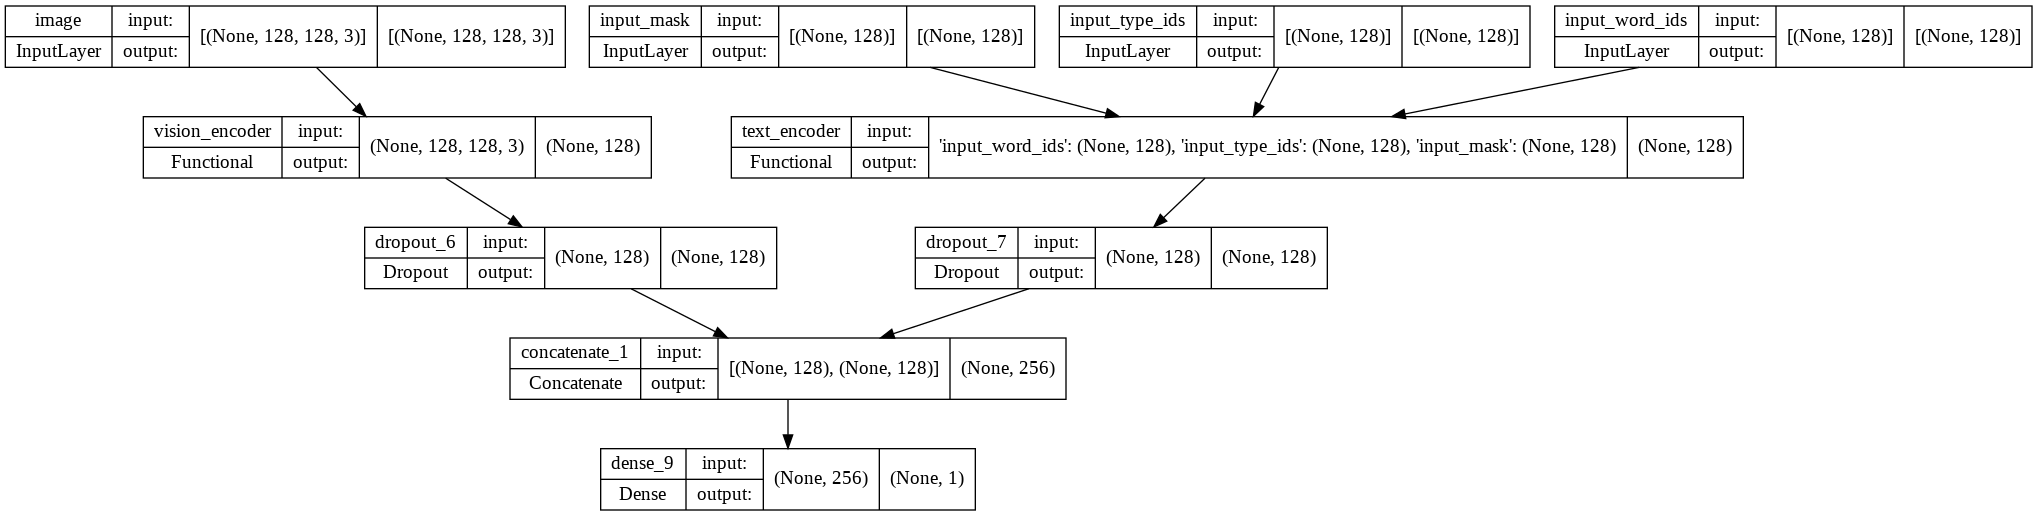

In [32]:
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [ ]:
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]

## Nike

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_nike, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'Total training examples: {len(train_df)}')
print(f'Total validation examples: {len(val_df)}')
print(f'Total test examples: {len(test_df)}')

train_df['class']=np.asarray(train_df['class']).astype(np.int)
val_df['class']=np.asarray(val_df['class']).astype(np.int)
test_df['class']=np.asarray(test_df['class']).astype(np.int)

train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

Total training examples: 7102
Total validation examples: 790
Total test examples: 877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

### Training the model

In [ ]:
history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
222/222 [==============================] - 120s 433ms/step - loss: 0.6551 - accuracy: 0.6688 - val_loss: 0.5859 - val_accuracy: 0.6709
Epoch 2/100
222/222 [==============================] - 94s 424ms/step - loss: 0.5386 - accuracy: 0.7315 - val_loss: 0.5714 - val_accuracy: 0.7076
Epoch 3/100
222/222 [==============================] - 94s 423ms/step - loss: 0.4671 - accuracy: 0.7803 - val_loss: 0.5885 - val_accuracy: 0.7013
Epoch 4/100
222/222 [==============================] - 94s 422ms/step - loss: 0.3735 - accuracy: 0.8389 - val_loss: 0.5901 - val_accuracy: 0.6937
Epoch 5/100
222/222 [==============================] - 94s 424ms/step - loss: 0.2726 - accuracy: 0.8861 - val_loss: 0.5123 - val_accuracy: 0.6975
Epoch 6/100
222/222 [==============================] - 94s 423ms/step - loss: 0.2151 - accuracy: 0.9038 - val_loss: 0.5613 - val_accuracy: 0.7076
Epoch 7/100
222/222 [==============================] - 94s 422ms/step - loss: 0.1851 - accuracy: 0.9024 - val_loss: 0.5572 

### Evaluating the model

In [ ]:
multimodal_model.evaluate(test_ds)

28/28 [==============================] - 10s 391ms/step - loss: 0.1723 - accuracy: 0.8527


[0.1723286136627197, 0.852697734451294]

## Ed Sheeran

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_edsheeran, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'Total training examples: {len(train_df)}')
print(f'Total validation examples: {len(val_df)}')
print(f'Total test examples: {len(test_df)}')

train_df['class']=np.asarray(train_df['class']).astype(np.int)
val_df['class']=np.asarray(val_df['class']).astype(np.int)
test_df['class']=np.asarray(test_df['class']).astype(np.int)

train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

Total training examples: 6125
Total validation examples: 681
Total test examples: 757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

### Training the model

In [ ]:
history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
192/192 [==============================] - 107s 426ms/step - loss: 0.3046 - accuracy: 0.8676 - val_loss: 0.2455 - val_accuracy: 0.8855
Epoch 2/100
192/192 [==============================] - 80s 417ms/step - loss: 0.2104 - accuracy: 0.9099 - val_loss: 0.2309 - val_accuracy: 0.8884
Epoch 3/100
192/192 [==============================] - 80s 417ms/step - loss: 0.1616 - accuracy: 0.9285 - val_loss: 0.2352 - val_accuracy: 0.8943
Epoch 4/100
192/192 [==============================] - 80s 416ms/step - loss: 0.0996 - accuracy: 0.9615 - val_loss: 0.2656 - val_accuracy: 0.8972
Epoch 5/100
192/192 [==============================] - 80s 416ms/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 0.2830 - val_accuracy: 0.9016
Epoch 6/100
192/192 [==============================] - 80s 417ms/step - loss: 0.0553 - accuracy: 0.9806 - val_loss: 0.3458 - val_accuracy: 0.8855
Epoch 7/100
192/192 [==============================] - 80s 416ms/step - loss: 0.0626 - accuracy: 0.9776 - val_loss: 0.4718 

### Evaluating the model

In [ ]:
multimodal_model.evaluate(test_ds)

24/24 [==============================] - 10s 391ms/step - loss: 0.2852 - accuracy: 0.9281


[0.2851786136627197, 0.928097734451294]

## Gucci

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_gucci, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'Total training examples: {len(train_df)}')
print(f'Total validation examples: {len(val_df)}')
print(f'Total test examples: {len(test_df)}')

train_df['class']=np.asarray(train_df['class']).astype(np.int)
val_df['class']=np.asarray(val_df['class']).astype(np.int)
test_df['class']=np.asarray(test_df['class']).astype(np.int)

train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

Total training examples: 7342
Total validation examples: 816
Total test examples: 907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

### Training the model

In [ ]:
history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
230/230 [==============================] - 103s 448ms/step - loss: 0.4647 - accuracy: 0.7999 - val_loss: 0.9729 - val_accuracy: 0.8039
Epoch 2/100
230/230 [==============================] - 103s 447ms/step - loss: 0.3268 - accuracy: 0.8614 - val_loss: 0.8865 - val_accuracy: 0.7933
Epoch 3/100
230/230 [==============================] - 103s 448ms/step - loss: 0.2554 - accuracy: 0.8950 - val_loss: 0.7713 - val_accuracy: 0.8039
Epoch 4/100
230/230 [==============================] - 103s 448ms/step - loss: 0.1905 - accuracy: 0.9224 - val_loss: 0.6183 - val_accuracy: 0.8021
Epoch 5/100
230/230 [==============================] - 103s 448ms/step - loss: 0.1649 - accuracy: 0.9336 - val_loss: 0.5838 - val_accuracy: 0.7032
Epoch 6/100
230/230 [==============================] - 103s 448ms/step - loss: 0.1438 - accuracy: 0.9393 - val_loss: 0.4430 - val_accuracy: 0.8375
Epoch 7/100
230/230 [==============================] - 103s 448ms/step - loss: 0.1214 - accuracy: 0.9523 - val_loss: 0

### Evaluating the model

In [ ]:
multimodal_model.evaluate(test_ds)

29/29 [==============================] - 14s 443ms/step - loss: 0.3047 - accuracy: 0.8807


[0.3046959659576416, 0.8806714696884155]

## Cristiano Ronaldo

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_cristianoronaldo, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'Total training examples: {len(train_df)}')
print(f'Total validation examples: {len(val_df)}')
print(f'Total test examples: {len(test_df)}')

train_df['class']=np.asarray(train_df['class']).astype(np.int)
val_df['class']=np.asarray(val_df['class']).astype(np.int)
test_df['class']=np.asarray(test_df['class']).astype(np.int)

train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

Total training examples: 5093
Total validation examples: 566
Total test examples: 629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

### Training the model

In [ ]:
history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
160/160 [==============================] - 71s 448ms/step - loss: 0.5852 - accuracy: 0.7142 - val_loss: 0.7475 - val_accuracy: 0.7145
Epoch 2/100
160/160 [==============================] - 71s 449ms/step - loss: 0.4942 - accuracy: 0.7631 - val_loss: 0.7182 - val_accuracy: 0.7292
Epoch 3/100
160/160 [==============================] - 71s 448ms/step - loss: 0.4309 - accuracy: 0.8007 - val_loss: 0.6887 - val_accuracy: 0.7659
Epoch 4/100
160/160 [==============================] - 71s 448ms/step - loss: 0.3508 - accuracy: 0.8445 - val_loss: 0.5738 - val_accuracy: 0.7904
Epoch 5/100
160/160 [==============================] - 72s 447ms/step - loss: 0.2578 - accuracy: 0.8931 - val_loss: 0.5810 - val_accuracy: 0.7549
Epoch 6/100
160/160 [==============================] - 73s 445ms/step - loss: 0.2015 - accuracy: 0.9134 - val_loss: 0.5728 - val_accuracy: 0.7875
Epoch 7/100
160/160 [==============================] - 72s 447ms/step - loss: 0.1985 - accuracy: 0.9157 - val_loss: 0.5262 -

### Evaluating the model

In [ ]:
multimodal_model.evaluate(test_ds)

20/20 [==============================] - 10s 435ms/step - loss: 0.2166 - accuracy: 0.9049


[0.2166393661499023, 0.904927649974823]